# Análise de Risco de Investimentos

## 1. Introdução

Neste notebook, realizaremos uma análise de risco para investimentos em ativos financeiros do mercado brasileiro. A análise utiliza:

- **Carteira de Pesos Iguais**: Onde todos os ativos possuem o mesmo peso no portfólio (para comparação).
- **Carteira Otimizada (Markowitz)**: Otimizada para minimizar a volatilidade com base na matriz de covariância dos retornos.
- **Comparação com o Índice IBOVESPA (BOVA11)**: Usado como benchmark.

### Metodologia
Os cálculos realizados incluem:
1. **Retornos Diários**: Calculados com base nos preços ajustados dos ativos.
2. **Volatilidade Anualizada**: Usada para avaliar o risco.
3. **Carteira Otimizada**: Calculada utilizando o método de Markowitz para encontrar a combinação ideal de ativos que minimize o risco.
4. **Retorno Acumulado**: Mostra a performance dos portfólios no período selecionado.

O notebook também permite ao usuário escolher:
- Os ativos para compor o portfólio.
- O período de análise: 1M (1 mês), 6M (6 meses), 1Y (1 ano), 3Y (3 anos) ou 5Y (5 anos).

### Objetivo
Este notebook ajuda investidores a visualizar e comparar a performance de diferentes estratégias de alocação de ativos. Os resultados são apresentados graficamente para facilitar a análise.

## 2. Importação de Bibliotecas

In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import minimize
from datetime import datetime, timedelta

## 3. Configuração dos Ativos

In [46]:
ativos = {
    "IBOVESPA": "BOVA11.SA",    
    "PETROBRAS": "PETR4.SA",    
    "JBS": "JBSS3.SA",          
    "ITAU": "ITUB4.SA",         
    "VALE3": "VALE3.SA",        
    "WEG": "WEGE3.SA",          
    "AMBEV": "ABEV3.SA",        
    "BB": "BBAS3.SA",           
    "BTG": "BPAC11.SA",         
    "BRADESCO": "BBDC4.SA",     
    "SANTANDER": "SANB11.SA",   
}

## 4. Definição de Funções

### Função para Determinar o Período

In [47]:
def definir_periodo(escolha):
    fim = datetime.now()
    if escolha == "1M":
        inicio = fim - timedelta(days=30)
    elif escolha == "6M":
        inicio = fim - timedelta(days=182)
    elif escolha == "1Y":
        inicio = fim - timedelta(days=365)
    elif escolha == "5Y":
        inicio = fim - timedelta(days=5 * 365)
    else:
        raise ValueError("Escolha inválida! Use: 1M, 6M, 1Y ou 5Y.")
    return inicio, fim

### Função para Baixar Dados

In [48]:
def baixar_dados(escolhas, periodo):
    inicio, fim = definir_periodo(periodo)
    ativos_selecionados = [ativos[ativo] for ativo in escolhas]
    dados = yf.download(ativos_selecionados, start=inicio, end=fim.strftime('%Y-%m-%d'))["Adj Close"]
    dados.columns = escolhas
    return dados.dropna()

### Funções para Calcular Carteiras

- Carteira de Pesos Iguais

In [49]:
def calcular_pesos_iguais(retornos):
    num_ativos = len(retornos.columns)
    pesos = np.array([1 / num_ativos] * num_ativos)
    retorno_carteira = (retornos @ pesos).cumsum()
    return pesos, retorno_carteira

- Carteira Otimizada (Markowitz)

In [50]:
def calcular_carteira_otimizada(retornos):
    cov_matrix = retornos.cov() * 252
    num_ativos = len(retornos.columns)

    def objetivo(pesos):
        return np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))

    restricao = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    limites = tuple((0, 1) for _ in range(num_ativos))
    pesos_iniciais = np.array([1 / num_ativos] * num_ativos)

    resultado = minimize(objetivo, pesos_iniciais, method="SLSQP", bounds=limites, constraints=restricao)
    pesos = resultado.x
    retorno_carteira = (retornos @ pesos).cumsum()
    return pesos, retorno_carteira

### Função para Gerar Gráfico

In [51]:
def gerar_grafico(retorno_iguais, retorno_otimizado, retorno_ibov):
    plt.figure(figsize=(14, 8))
    plt.plot(retorno_otimizado, label="Carteira Otimizada", color="green")
    plt.plot(retorno_iguais, label="Carteira Pesos Iguais", color="orange")
    plt.plot(retorno_ibov, label="IBOVESPA (BOVA11)", color="blue")
    plt.axhline(0, color="gray", linestyle="--", linewidth=1, alpha=0.8)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    final_values = {
        "Carteira Otimizada": (retorno_otimizado.iloc[-1].item(), "green"),
        "Carteira Pesos Iguais": (retorno_iguais.iloc[-1].item(), "orange"),
        "IBOVESPA (BOVA11)": (retorno_ibov.iloc[-1].item(), "blue"),
    }
    for label, (value, color) in final_values.items():
        bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor=color, alpha=0.6)
        plt.text(retorno_otimizado.index[-1], value, f"{value:+.2%}", fontsize=12, color="white", ha="left", va="center", bbox=bbox_props)
    plt.title("Comparação de Carteiras")
    plt.xlabel("Período")
    plt.ylabel("Retorno Acumulado (%)")
    plt.legend()
    plt.grid()
    plt.show()

## 5. Escolha dos Ativos e Período

In [52]:
# Simulação com escolhas do usuário
escolhas_usuario = ["PETROBRAS", "ITAU", "JBS", "BB", "BRADESCO", "SANTANDER"]  # Exemplo de escolha do usuário
periodo_usuario = "1Y"  # Exemplo de escolha do período (1M, 6M, 1Y, 3Y ou 5Y)

## 6. Execução do Cálculo e Visualização

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed


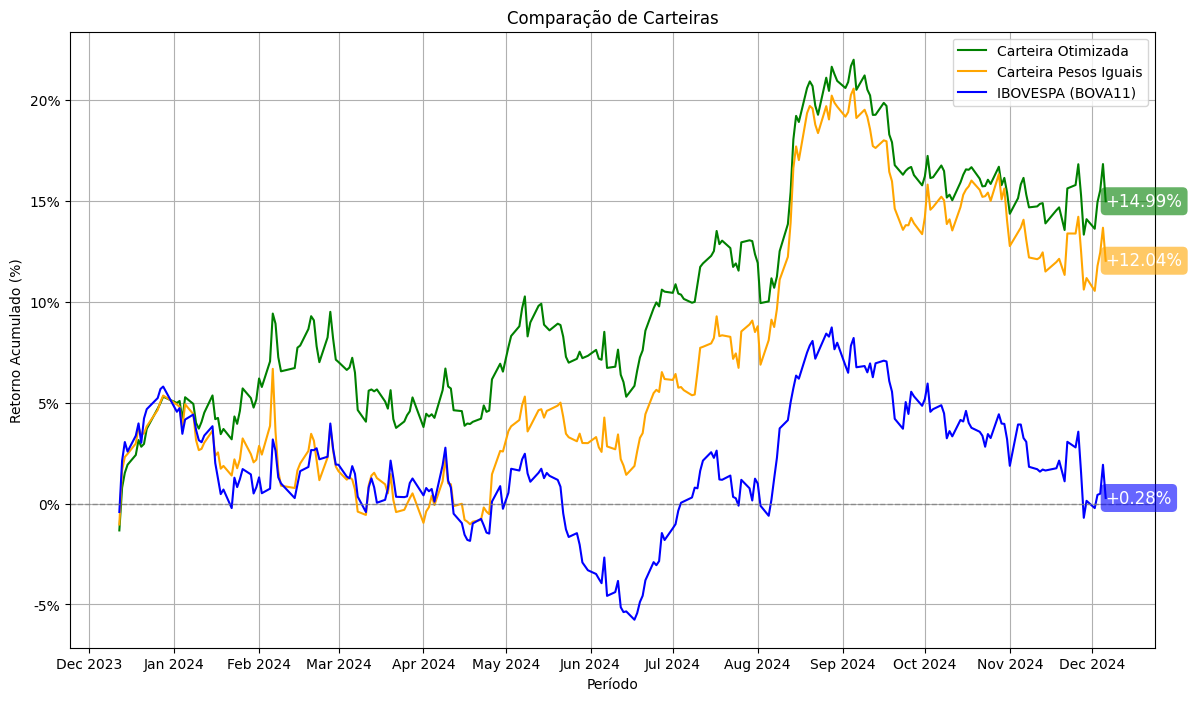


Pesos Iguais da Carteira:
PETROBRAS: 16.67%
ITAU: 16.67%
JBS: 16.67%
BB: 16.67%
BRADESCO: 16.67%
SANTANDER: 16.67%

Pesos Otimizados da Carteira:
PETROBRAS: 28.94%
ITAU: 1.40%
JBS: 25.39%
BB: 11.93%
BRADESCO: 22.29%
SANTANDER: 10.06%


In [53]:
# Baixando dados
dados_escolhidos = baixar_dados(escolhas_usuario, periodo_usuario)
retornos = dados_escolhidos.pct_change().dropna()

# Calculando carteiras
pesos_iguais, retorno_iguais = calcular_pesos_iguais(retornos)
pesos_otimizados, retorno_otimizado = calcular_carteira_otimizada(retornos)

# Comparação com IBOVESPA (BOVA11)
dados_ibov = baixar_dados(["IBOVESPA"], periodo_usuario)
retorno_ibov = dados_ibov.pct_change().dropna().cumsum()

# Gerar o gráfico
gerar_grafico(retorno_iguais, retorno_otimizado, retorno_ibov)

# Exibir resultados
print("\nPesos Iguais da Carteira:")
for ativo, peso in zip(escolhas_usuario, pesos_iguais):
    print(f"{ativo}: {peso:.2%}")

print("\nPesos Otimizados da Carteira:")
for ativo, peso in zip(escolhas_usuario, pesos_otimizados):
    print(f"{ativo}: {peso:.2%}")

### Matriz de Correlação
Matriz de Correlação dos ativos escolhidos pelo usuário.


Matriz de Correlação:
           PETROBRAS      ITAU       JBS        BB  BRADESCO  SANTANDER
PETROBRAS   1.000000  0.412147  0.564821  0.125745  0.194806   0.430343
ITAU        0.412147  1.000000  0.507137  0.141975  0.023096   0.471601
JBS         0.564821  0.507137  1.000000  0.173563  0.045443   0.495546
BB          0.125745  0.141975  0.173563  1.000000 -0.009766   0.259151
BRADESCO    0.194806  0.023096  0.045443 -0.009766  1.000000   0.110999
SANTANDER   0.430343  0.471601  0.495546  0.259151  0.110999   1.000000


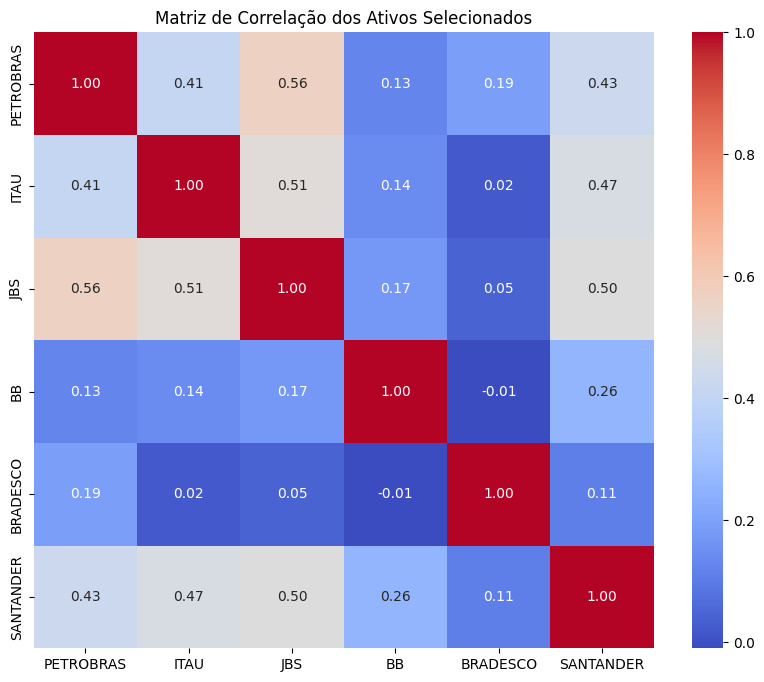

In [54]:
# Calcular a matriz de correlação
correlacao = retornos.corr()

# Exibir a matriz de correlação
print("\nMatriz de Correlação:")
print(correlacao)

# Visualizar a matriz de correlação como um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matriz de Correlação dos Ativos Selecionados")
plt.show()
